In [127]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym
import imageio
from collections import deque
from IPython.display import Video
from numba import jit
from random import random, randint, sample

from tetris_gymnasium.envs.tetris import Tetris
from tetris_gymnasium.wrappers.grouped import GroupedActionsObservations
from tetris_gymnasium.mappings.rewards import RewardsMapping

In [128]:
def make_custom_tetris_env(
    alife=1,
    clear_line=1,
    game_over=0,
    invalid_action=-1,
    render_mode=None
):

    # Create custom reward map
    custom_map = RewardsMapping(
        alife=alife,
        clear_line=clear_line,
        game_over=game_over,
        invalid_action=invalid_action
    )

    # Initialize env with reward override
    env = gym.make(
        "tetris_gymnasium/Tetris",
        rewards_mapping=custom_map,
        render_mode=render_mode  # Uncomment if needed
    )
    
    env = GroupedActionsObservations(env)
    
    return env

In [129]:
@jit(nopython=True)
def calculate_features_numba(inner_boards, lines_cleared_norm):
    """
    JIT-compiled feature calculation
    """
    num_actions, rows, cols = inner_boards.shape
    features = np.zeros((num_actions, 4), dtype=np.float32)
    
    for i in range(num_actions):
        board = inner_boards[i]
        
        # Heights
        heights = np.zeros(cols, dtype=np.int32)
        for col in range(cols):
            for row in range(rows):
                if board[row, col] != 0:
                    heights[col] = rows - row
                    break
        
        agg_height = np.sum(heights)
        
        # Holes
        holes = 0
        for col in range(cols):
            found_surface = False
            for row in range(rows):
                if board[row, col] != 0:
                    found_surface = True
                elif found_surface:
                    holes += 1
        
        # Bumpiness
        bumpiness = 0
        for col in range(cols - 1):
            bumpiness += abs(heights[col] - heights[col + 1])
        
        features[i] = [
            agg_height,
            lines_cleared_norm,
            holes,
            bumpiness
        ]
    
    return features

def extract_features_from_observations(board_state, info):
    """
    Numba-accelerated version
    """
    # Batch extract inner boards
    inner_boards = board_state[:, :-4, 4:-4]
    
    if isinstance(inner_boards, torch.Tensor):
        inner_boards = inner_boards.cpu().numpy()
    
    inner_boards = np.where(inner_boards == 1, 0, inner_boards)
    
    # JIT-compiled feature calculation
    features = calculate_features_numba(inner_boards, info["lines_cleared"] / 4.0)
    
    return torch.from_numpy(features)

@jit(nopython=True)
def calculate_features_numba_single(inner_boards, lines_cleared_norm):
    """
    JIT-compiled feature calculation
    """
    rows, cols = inner_boards.shape
    
    features = []
    
    board = inner_boards
        
    # Heights
    heights = np.zeros(cols, dtype=np.int32)
    for col in range(cols):
        for row in range(rows):
            if board[row, col] != 0:
                heights[col] = rows - row
                break
    
    agg_height = np.sum(heights)
    
    # Holes
    holes = 0
    for col in range(cols):
        found_surface = False
        for row in range(rows):
            if board[row, col] != 0:
                found_surface = True
            elif found_surface:
                holes += 1
    
    # Bumpiness
    bumpiness = 0
    for col in range(cols - 1):
        bumpiness += abs(heights[col] - heights[col + 1])
        
    features.append([agg_height, lines_cleared_norm, holes, bumpiness])
    
    return features

def extract_features_from_observations_single(board_state, info):
    """
    Numba-accelerated version
    """
    # Batch extract inner boards
    inner_boards = board_state[:-4, 4:-4]

    
    if isinstance(inner_boards, torch.Tensor):
        inner_boards = inner_boards.cpu().numpy()
    
    inner_boards = np.where(inner_boards == 1, 0, inner_boards)
    
    # JIT-compiled feature calculation
    features = calculate_features_numba_single(inner_boards, info["lines_cleared"] / 4.0)
    
    return torch.from_numpy(np.array(features, dtype=np.float32))

In [130]:
import torch.nn as nn

class DQN_CNN(nn.Module):
    def __init__(self):
        super(DQN_CNN, self).__init__()

        self.conv1 = nn.Sequential(nn.Linear(4, 64), nn.ReLU(inplace=True))
        self.conv2 = nn.Sequential(nn.Linear(64, 64), nn.ReLU(inplace=True))
        self.conv3 = nn.Sequential(nn.Linear(64, 1))

        self._create_weights()

    def _create_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        return x

In [131]:
def train_dqn_cnn(episodes=3000, batch_size=512, gamma=0.99, lr=1e-4,
                   epsilon_initial=1.0, epsilon_min=1e-3, epsilon_decay=0.9985,
                   target_update=1000, replay_memory_size=30000, num_decay_epochs=2000):
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(123)
    else:
        torch.manual_seed(123)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    env = make_custom_tetris_env()
    DQN_Model = DQN_CNN().to(device)
    optimizer = torch.optim.Adam(DQN_Model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    rewards_history = []
    lines_history = []

    replay_memory = deque(maxlen=replay_memory_size)
    for ep in range(episodes):
        state, info = env.reset()
        done = False
        
        features_before = torch.zeros(4, device='cuda:0')
        
        lines_cleared = 0
        total_reward = 0
        
        while not done:
            epsilon = epsilon_min + (max(num_decay_epochs - ep, 0) * (epsilon_initial - epsilon_min) / num_decay_epochs)

            # Extract normalized features for all possible placements
            # state shape: (40, 20, 10) -> features shape: (40, 4)
            features = extract_features_from_observations(state, info).to(device)
            
            DQN_Model.eval()
            with torch.no_grad():
                prediction = DQN_Model(features)[:, 0]  # Shape: (40,)
            DQN_Model.train()
            
            legal_actions = info.get('action_mask', None)
            if legal_actions is not None:
                if hasattr(legal_actions, 'numpy'):
                    legal_actions = legal_actions.numpy()
                legal_indices = np.where(legal_actions)[0]
                
                if np.random.rand() < epsilon:
                    # Explore: random legal action
                    action = np.random.choice(legal_indices)
                else:
                    # Exploit: best legal action
                    legal_tensor = torch.tensor(legal_actions, dtype=torch.bool, device=device)
                    masked_q_values = prediction.clone()
                    masked_q_values[~legal_tensor] = -float('inf')
                    action = masked_q_values.argmax().item()
            else:
                # No legal action masking
                if np.random.rand() < epsilon:
                    action = env.action_space.sample()
                else:
                    action = prediction.argmax().item()
        
            features_recommended = features[action, :]
            # features_current = extract_features_from_observations_single(state[action], info)
            # print("Before", features_before)
            # print("After", features_recommended)
            
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            replay_memory.append([features_before, reward, features_recommended, done])
            
            features_before = features_recommended
            
            # if info["lines_cleared"] == 1:
            #     reward *= 10
            if info["lines_cleared"] == 2:
                reward *= 2
            elif info["lines_cleared"] == 3:
                reward *= 3
            elif info["lines_cleared"] >= 4:
                reward *= 4
            
            lines_cleared += info["lines_cleared"]
            total_reward += reward

            if len(replay_memory) < replay_memory_size / 10:
                continue
            batch = sample(replay_memory, min(len(replay_memory), batch_size))
            state_batch, reward_batch, next_state_batch, done_batch = zip(*batch)
            state_batch = torch.stack(tuple(state for state in state_batch))
            reward_batch = torch.from_numpy(np.array(reward_batch, dtype=np.float32)[:, None])
            next_state_batch = torch.stack(tuple(state for state in next_state_batch))
            
            if torch.cuda.is_available():
                state_batch = state_batch.cuda()
                reward_batch = reward_batch.cuda()
                next_state_batch = next_state_batch.cuda()

            q_values = DQN_Model(state_batch)
            DQN_Model.eval()
            with torch.no_grad():
                next_prediction_batch = DQN_Model(next_state_batch)
            DQN_Model.train()

            y_batch = torch.cat(
                tuple(reward if done else reward + gamma * prediction for reward, done, prediction in
                    zip(reward_batch, done_batch, next_prediction_batch)))[:, None]
            
            state = next_state
            
            optimizer.zero_grad()
            loss = criterion(q_values, y_batch)
            loss.backward()
            optimizer.step()
            
        rewards_history.append(total_reward)
        lines_history.append(lines_cleared)
        
        print(f"Episode {ep}, Total Reward: {total_reward:.2f}, Lines Cleared: {lines_cleared}, Epsilon: {epsilon:.3f}")
            
    return DQN_Model, rewards_history, lines_history

In [132]:
q_net, history, lines = train_dqn_cnn(episodes=2500)

Using device: cuda
Episode 0, Total Reward: 15.00, Lines Cleared: 0, Epsilon: 1.000
Episode 1, Total Reward: 17.00, Lines Cleared: 0, Epsilon: 1.000
Episode 2, Total Reward: 16.00, Lines Cleared: 0, Epsilon: 0.999
Episode 3, Total Reward: 19.00, Lines Cleared: 0, Epsilon: 0.999
Episode 4, Total Reward: 22.00, Lines Cleared: 0, Epsilon: 0.998
Episode 5, Total Reward: 15.00, Lines Cleared: 0, Epsilon: 0.998
Episode 6, Total Reward: 16.00, Lines Cleared: 0, Epsilon: 0.997
Episode 7, Total Reward: 14.00, Lines Cleared: 0, Epsilon: 0.997
Episode 8, Total Reward: 16.00, Lines Cleared: 0, Epsilon: 0.996
Episode 9, Total Reward: 18.00, Lines Cleared: 0, Epsilon: 0.996
Episode 10, Total Reward: 18.00, Lines Cleared: 0, Epsilon: 0.995
Episode 11, Total Reward: 13.00, Lines Cleared: 0, Epsilon: 0.995
Episode 12, Total Reward: 20.00, Lines Cleared: 0, Epsilon: 0.994
Episode 13, Total Reward: 24.00, Lines Cleared: 0, Epsilon: 0.994
Episode 14, Total Reward: 19.00, Lines Cleared: 0, Epsilon: 0.993
E

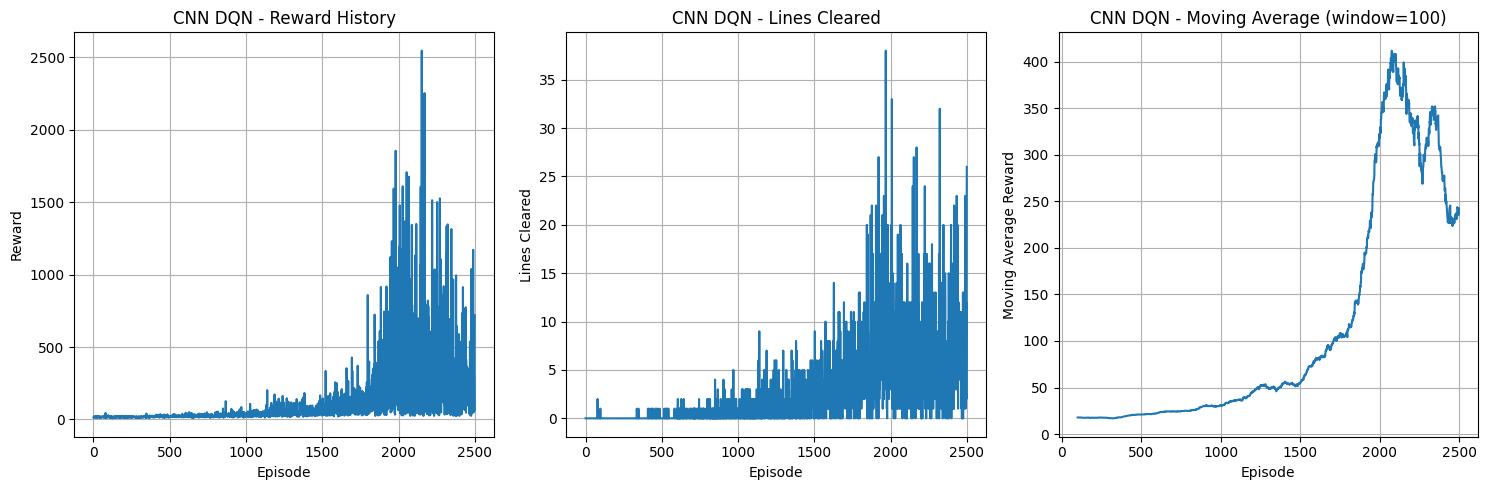


📊 Final Training Statistics:
Total Episodes: 2500
Average Reward (last 100): 242.40
Best Reward: 2546.00
Total Lines Cleared: 6479
Average Lines/Episode: 2.59
Max Lines in Single Episode: 38


In [133]:
# Plot training results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("CNN DQN - Reward History")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(lines)
plt.xlabel("Episode")
plt.ylabel("Lines Cleared")
plt.title("CNN DQN - Lines Cleared")
plt.grid(True)

plt.subplot(1, 3, 3)
# Moving average for smoother visualization
window = 100
if len(history) >= window:
    moving_avg = np.convolve(history, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(history)), moving_avg)
    plt.xlabel("Episode")
    plt.ylabel("Moving Average Reward")
    plt.title(f"CNN DQN - Moving Average (window={window})")
    plt.grid(True)

plt.tight_layout()
plt.show()

# Print final statistics
print("\n📊 Final Training Statistics:")
print(f"Total Episodes: {len(history)}")
print(f"Average Reward (last 100): {np.mean(history[-100:]):.2f}")
print(f"Best Reward: {np.max(history):.2f}")
print(f"Total Lines Cleared: {sum(lines)}")
print(f"Average Lines/Episode: {np.mean(lines):.2f}")
print(f"Max Lines in Single Episode: {np.max(lines)}")


In [134]:
# Evaluate trained CNN DQN and save gameplay video
device = next(q_net.parameters()).device
env = make_custom_tetris_env(render_mode="rgb_array")
video_path = "tetris_cnn_eval.mp4"
writer = imageio.get_writer(video_path, fps=30)
episodes = 10

print(f"\n🎮 Evaluating trained agent for {episodes} episodes on {device}...\n")

for ep in range(episodes):
    state, info = env.reset()
    done = False
    total_reward = 0
    lines_cleared = 0

    while not done:
        # Extract features for all possible placements
        # state shape: (N, H, W) -> features shape: (N, 4)
        features = extract_features_from_observations(state, info).to(device)

        # Compute Q-values for all placements
        with torch.no_grad():
            q_values = q_net(features)  # Shape: (N,)

        # Legal action masking
        legal_actions = info.get("action_mask", None)
        if legal_actions is not None:
            if hasattr(legal_actions, "numpy"):
                legal_actions = legal_actions.numpy()
            legal_indices = np.where(legal_actions)[0]
            legal_tensor = torch.tensor(legal_actions, dtype=torch.bool, device=device)
            masked_q_values = q_values.clone()
            masked_q_values[~legal_tensor] = -float("inf")
            action = masked_q_values.argmax().item()
        else:
            action = q_values.argmax().item()

        # Step environment
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward
        lines_cleared += info.get("lines_cleared", 0)
        state = next_state

        # Render frame and append to video
        frame = env.render()
        writer.append_data(np.asarray(frame).astype(np.uint8))

    print(f"Episode {ep+1}/{episodes} | Total Reward: {total_reward:.2f} | Lines Cleared: {lines_cleared}")

writer.close()
env.close()
print(f"\n🎥 Video saved to {video_path}")


🎮 Evaluating trained agent for 10 episodes on cuda:0...



IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (340, 240) to (352, 240) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 1/10 | Total Reward: 384.00 | Lines Cleared: 20
Episode 2/10 | Total Reward: 201.00 | Lines Cleared: 10
Episode 3/10 | Total Reward: 56.00 | Lines Cleared: 2
Episode 4/10 | Total Reward: 193.00 | Lines Cleared: 11
Episode 5/10 | Total Reward: 85.00 | Lines Cleared: 4
Episode 6/10 | Total Reward: 117.00 | Lines Cleared: 5
Episode 7/10 | Total Reward: 167.00 | Lines Cleared: 9
Episode 8/10 | Total Reward: 275.00 | Lines Cleared: 16
Episode 9/10 | Total Reward: 84.00 | Lines Cleared: 4
Episode 10/10 | Total Reward: 182.00 | Lines Cleared: 10

🎥 Video saved to tetris_cnn_eval.mp4


In [135]:
Video("tetris_cnn_eval.mp4", embed=True)